# Training LLMs - Fine Tuning Language Model on Semantic Tasks

In this assignment we are going to fine tune an off the shelf pre-trained language model to understand semantic similarity. To do this we are going to use the Glue - MSRC dataset provided by microsoft to understand such semantics.

The goal for this assignment is to take an off the shelf language model that is already pre-trained and fine tune it on the task understanding semantic analysis. The languge model that we are going to use is the base `roberta` model that is larger than the original base `bert` model. There are other modifications that `roberta` did to enhance `bert` such as dynamic masking, the removal of the next sentence prediction task, as well as a more enhanced tokenzer.

This assignment will walk you through the steps needed to accomplish this task. You will be asked to fill in the various code blocks as we progress through the notebook. Please view the comments to monitor which code blocks to complete.

In [1]:
# let's first install the various libraries that we'll
# need for this assignment
!pip install -q peft datasets evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
! pip install transformers[torch]

In [3]:
# we are going to import
# the various methods and classes that we will use
# throughout the notebook.
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
from peft import (
    get_peft_config,
    get_peft_model,
    LoraConfig,
    TaskType
    )
from datasets import load_dataset
import evaluate
import torch
import numpy as np

# we are going to pull in the RoBERTA model
# which is a modification of BERT
model_name_or_path = "roberta-base"
# this is going to be the specific dataset that
# we are pulling from load dataset.
# this data allows us to understand
# semantic similarity between documents.
task = "mrpc" # microsoft research paraphrase corpus

PEFT is Parameter Efficient Fine Tuning.

As can be seen, this is a typical classification setup. We are given train, validation, and test sets. In most classifications, we don't need big models. In this case, we are dealing with a model called RoBERTa, which is an extension of BERT. MRPC is also a classification task.

As a recap of BERT:

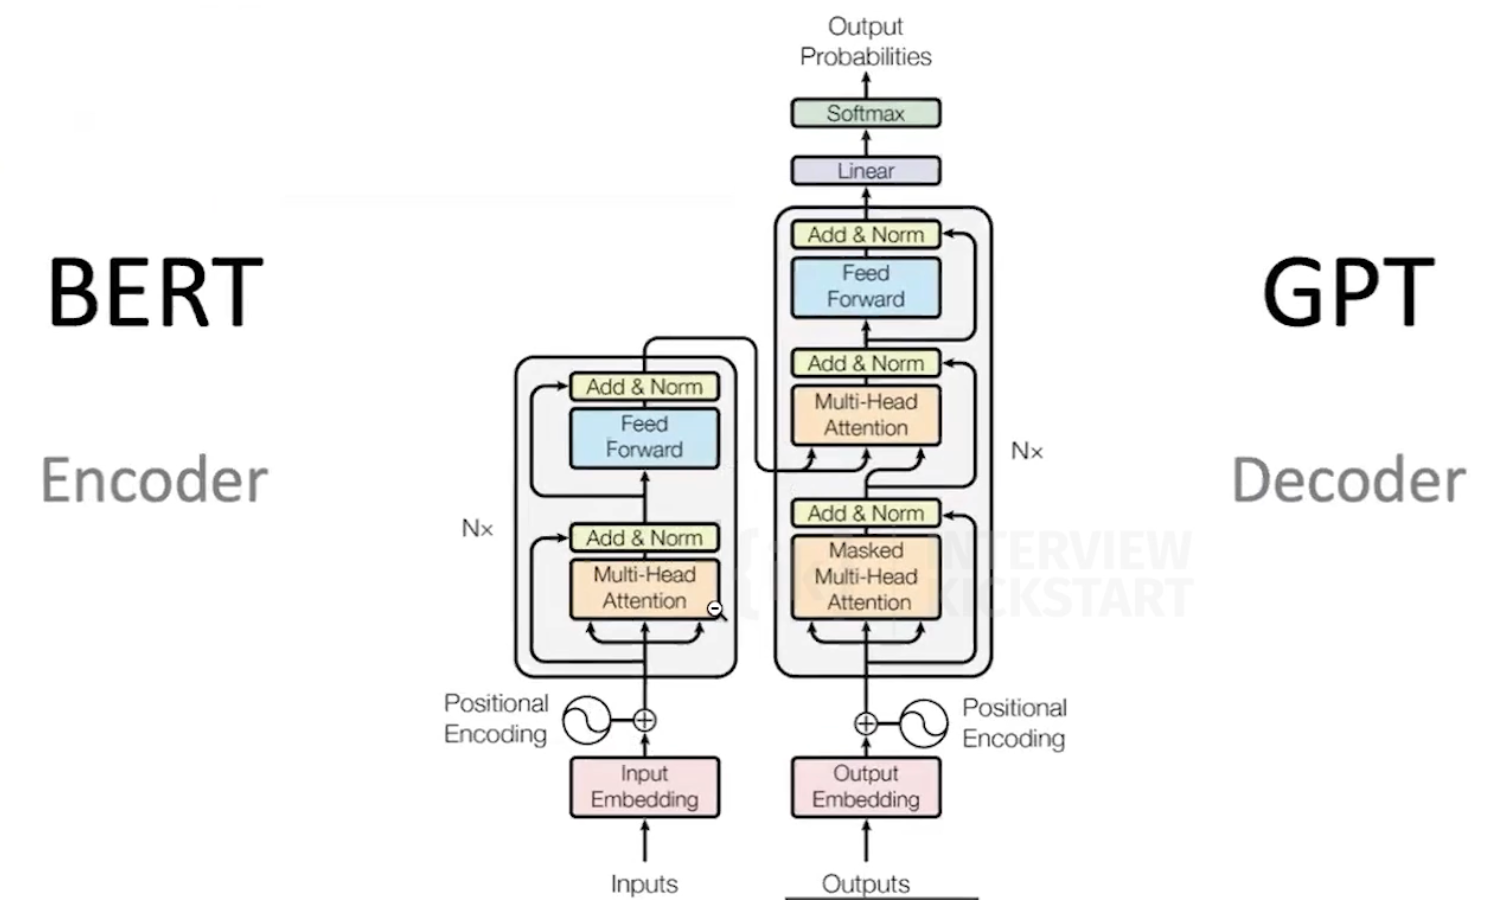

We give an input and predict an output. BERT had two tasks. One of them being Masked Language Model.

Pretraining Tasks:

test = My name is BERT. I love Machine Learning. I'm from Google.

Task 1: MLM - Masked Language Model                            Y
My [MASK] is BERT.
I love [MASK] Learning.
[MASK] from Google.

BERT's task is to predict what the word for MASK is.

Task 2: NSP - Next Sentence Prediction
My name is BERT. [SEP] I love Machine Learning. [SEP] I am from Google.

Notice every sentence has a separator. BERT has to predict the next sentence has to be the same. Let's continue from the example.

x                                                    y
My name is BERT. [SEP] I love Machine Learning.      1
My name is BERT. [SEP] I am from Google.             0

BERT was created as a model to understand the language, but its limitation is predicting the next token.

We can finetune BERT on downstream tasks.

Downstream Task:
1. Classification (sentiment, spam, fake news)
2. NER (Named Entity Recognition)
3. QA (Question Answering)
4. Summarization
5. Tranlation
6. Text Generation
7. etc.

RoBERTa, Robustly Optimized BERT, by Facebook is an extension of BERT. It had longer hours of training on more data. This model doesn't use NSP, but mainly focused on MLM. Where BERT had static masking, Facebook used dynamic masking, i.e., every epoch a randomized token is masked, which made it more robust during training.

We can use any model, but because this is only a classification task, we will use a simple model that can fit on our GPU.

In [4]:
# Original Text = My name is Chirag. I love Machine Learning. I am from India.

# Self Supervised Learning (SSL)

# Pretraining Tasks:
# ---
# Task 1: MLM Masked Language Model
# ---
# My [MASK] is Chirag.
# I love [MASK] Learning.
# I am from [MASK].

# Task 2: NSP Next Sentence Prediction
# ---
# My name is Chirag. [SEP] I love Machine Learning. [SEP] I am from India.
# My name is Chirag. [SEP] I love Machine Learning.       1
# My name is Chirag. [SEP] I am from India.               0



# Downstream Task (SFT / RFT):
# --
# 1. Classification (sentiment, spam, fake news)
# 2. NER (Named Entity Recognition)
# 3. QA (Question Answering)
# 4. Summarization
# 5. Translation
# 6. Text Generation
# 7. etc.

Model1 : Trained(Base) + Classification (sentiment)  1000

Model2 : Trained(Base) + Classification (spam) 1000

Model3 : Trained(Base) + Classification (fake news)  1000

General Classification Model: Trained(Base) + Classification (sentiment, spam, fake news)

General Chat Model: Trained(Base) + Tasks (Chat(Classification (sentiment, spam, fake news), NER (Named Entity Recognition), QA (Question Answering)))

Any machine learning model needs two things - input and output. We calculate the loss on the output. When we have a good amount of data that is unlabeled we have to convert some into input/output pair so that we can calculate the loss on the output pair, therefore optimizing the model.

The pretext tasks are not the tasks that we're trying to solve. For example, if we were trying to solve the sentiment, spam, fake news classification task, then we don't need to do the pretext tasks. It's just that for our use case, in hand, we may have some thousand labeled examples of sentiments, and we have a good amount of unlabeled data, which is just web text. GPT models are trained on the pretext tasks and they are called the Base model. There's an Instruct model, which are finetuned from the base models. Chat models are over the instruct models. The instruct and chat models are downstream models, which are supervised finetuning models, as well as, reinforcement finetuning. Downstream models use the weights of the base models. We can achieve generalization even if we only have a thousand examples.

Pretraining is common, except that in BERT the tasks are different because the volume of data is different. The number of parameters are also different. We are limiting ourselves to RoBERTa base, a 500 million parameter model, which fits into this lesson.

In [ ]:
# Random Weights (Base)
# Base: Pretrain (Pretext tasks) (1B + 30 days -> 100k epochs)
# 1. Next token prediction
# 2. Masked Language Model
#Trained Weights which understands meaning of tokens and sentences of the given langauge


# Continue/Finetune the weights of the pretrained model
# Downstream Models (SFT/ RFT): (1k + hours + 2 epochs)
## 1. Instruct Model [
##    X                                   y
##  "Convert the given text to JSON" ,  "{''}"
## 2. Chat Model.  [
###    [USER]: Convert the given text to JSON.                                                                                           [ASSISTANT]: Here is you JSON.
      #  [USER]: I want this in markdown ```json```                                                                                        [ASSISTANT]: some answer
      #  [USER]: Convert the given text to JSON. [ASSISTANT]: Here is you JSON. [USER]: I want this in markdown ```json```                 [ASSISTANT]: some answer
###
# 3. Classifcation:
# "I hate this product"           1
# "I love this product            0


The difference between an instruct and chat model is that only one instruction is given in the instruct model. i.e., do "xyz" and an output is given, e.g. convert the given text to json and the output would be a json. Multiple users are not involved. Whereas, in the chat model, there is a user prompt: "[User]: Convert the given text to JSON", and there is an assistant: "[ASSISTANT]: Here is your JSON".

Some times when we have an instruction model, we can finetune to be a chat model. There are some models that have gone from base to chat.


Below, we load the dataset with a task that is are already defined in the library, which means it has access to the dataset to download it so we don't have to do anything else.

This is a standard dataset on Huggingface. "glue" is a metric (see https://gluebenchmark.com/).

In [5]:
# let's load in the glue dataset with the MRPC task
dataset = load_dataset("glue", task)

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/649k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [6]:
# let's view the data set as a whole
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

If the dataset wasn't given to us, then we would have to prepare it ourselves by CSV data splitting.

We can convert the dataset to Pandas to get a tabular view.

In [7]:
import pandas as pd
dataset.set_format(type="pandas")
df = dataset["train"][:]
df.head()

,sentence1,sentence2,label,idx
0,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",1,0
1,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,0,1
2,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",1,2
3,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",0,3
4,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,1,4


Afterward, we need to convert back to continue.

In [8]:
dataset.reset_format()

In [9]:
# look at a few records of the train dataset.
# label refers to if those sentences are indeed
# similar

## code here
dataset['train'][0]

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'label': 1,
 'idx': 0}

In [10]:
x = dataset['train'][0]

In [11]:
x

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'label': 1,
 'idx': 0}

In [11]:
x = {"X": x["sentence1"] + x["sentence2"], "Y": x["label"]}

In [12]:
x

{'X': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'Y': 1}

As is typical when fine tuning language models, we need to create a function that will keep track of metrics while training. In order to do this we are going to use the native metric that is seen in the GLEU dataset creation.

For more information on the GLUE Metric and Datasets, please view this link: [GLEU](https://huggingface.co/spaces/evaluate-metric/glue).

In [13]:
# at this point we are going to load in the metric
# that we should be using when evaluating the MRPC dataset.
# we will use this as part of computing metrics
metric = evaluate.load("glue", task)

Instead of writing all of this by ourselves, Huggingface has very good bootstrapping. The evaluate library has a lot of metrics.

In [14]:
# let's visualize what this metric
# looks like.
metric

EvaluationModule(name: "glue", module_type: "metric", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = evaluate.load('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=ref

In [15]:
# we can see an example here
# between references and predictions
# this metric is how we will account for
# the training and validation loss during
# model training
references = [0, 1]
predictions = [1, 1]
results = metric.compute(predictions=predictions, references=references)
print(results)

{'accuracy': 0.5, 'f1': 0.6666666666666666}


In [16]:
# go ahead and write a compute_metrics
# function that will take an eval_pred
# object and return the metric calculation
# of the predictions vs the labels.

## code here
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Now that we have a model we have to fine tune it. Here's an example of the data.

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'label': 1,
 'idx': 0}

 We pass 2 sentences and a label for training.

  'sentence1' 'sentence2'     label

To do this, we have to tokenize because the model only understands the tokens. Fortunately, every model comes with a tokenizer. (See the tokenizer.json, tokenizer_config.json and vocab.json at https://huggingface.co/FacebookAI/roberta-base/tree/main)

Below we look at the end-of-sentence token id.

We use Huggingface's AutoTokenizer library to load in the requisite tokenizer. The function truncates or pads the sentences so they are the same length. The sentence can be padded either on the left or right.

In [18]:
# load in the requisite tokenizer for the RoBERTA model
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side="right")
if getattr(tokenizer, "pad_token_id") is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

# write a function that will take in a batch (or example)
# and tokenize both the first sentence and second sentence
# make sure to truncate the text and don't worry about the max length for now.

## code here
def tokenize_function(examples):
    outputs = tokenizer(examples["sentence1"], examples["sentence2"], truncation=True, max_length=None)
    return outputs

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [19]:
tokenizer.eos_token_id

2

In [ ]:
# df.apply(functio)
# dataset.map()

In [20]:
# take your just written tokenize function
# and tokenize the entire dataset that we
# pulled in at the beginning

## code here
tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["idx", "sentence1", "sentence2"],
)

# afterwards, rename the "label" feature as "labels"

## code here
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [21]:
# view the first few examples of
# your tokenized data set to see what it looks
# like.
x = tokenized_datasets['train'][0]

We see labels, input_ids, and attention_mask. We haven't trained the model yet. We are preparing the data for the model. Currently, nothing is masked. We want to see all tokens.

In [22]:
x['labels']

1

The input_ids are what we will feed to the model.

In [23]:
x['input_ids']

[0,
 10127,
 1001,
 6182,
 1238,
 39,
 2138,
 2156,
 2661,
 37,
 373,
 22,
 5,
 4562,
 22,
 2156,
 9,
 12507,
 7018,
 23817,
 39,
 1283,
 479,
 2,
 2,
 48310,
 4506,
 7,
 123,
 25,
 129,
 22,
 5,
 4562,
 22,
 2156,
 1918,
 1001,
 6182,
 1238,
 39,
 2138,
 9,
 12507,
 7018,
 23817,
 39,
 1283,
 479,
 2]

In [24]:
# so that you van view get the input ids from any
# example that you choose, and run it through the following code,
# what do you notice?
example_input_ids = tokenized_datasets['train'][1]['input_ids']
tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(example_input_ids))

"<s>Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .</s></s>Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .</s>"

In [ ]:
# 50 x 50

In [25]:
len(tokenized_datasets['train'])

3668

At this stage, the data preparation and tokenization has been done. Each and every row are of the same dimension. We have a matrix. We can't see all this because it is lazy execution.

The decoding steps above allows you to see what's going on under the hood. None of it is used in the modeling pipeline.

In [26]:
# let's now make a DataCollator object will dynamically pad
# our inputs using the tokenizer in question.
# ideally we want to pad to the longest sentences that we see in question.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")

## Fine Tuning Languge Model
Let's first fine tune the full language model. We will then compare it to fine tuning on the PEFT version and notice any major differences.

In [27]:
# pull in the RoBERTA model
# remember to use AutoModelForSequenceClassification
# class because we are going to be classifying on a known label.
model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, return_dict=True)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
## find the number of trainable parameters that this model
## will use when fine tuning

## code here
sum(p.numel() for p in model.parameters())

124647170

Below, we pass in parameters for finetuning. We set up a low learning rate, which relates to gradient descent. The weight decay is the decay that happens over the learning rate. We don't want to have a constant learning rate; therefore, there is a weight_decay. Once an epoch is complete evaluate then. There are occasions where the evaulation occurs in between. Let's say there is a hundred batches in an epoch, the evaluation occurs after 50 steps. Checkpoint is saved after every epoch, but log after every hundred steps. This also means that thee are 200 steps in an epoch. After 200 batches the log gets printed.

Once training is complete, the best model is loaded based on the evaluation number into the memory back.

The default gradient descent algorithm, which isn't shown is Adam. We can specify a different algorithm such as SG Grad or RMS prop should we choose.
Since we have the weights, how we optimize further is our choice. BTW, Adam is the most safest. (See optimizer which is a tuple shown on https://huggingface.co/docs/transformers/main_classes/trainer)

As a rule of thumb, use a learning rate that is lower than the model used for pretraining. Generally, the models will show this. If we trained if a larger learning rate then the model may forget what it learned earlier in the base model; therefore, we use a smaller learning rate.

In [29]:
## using the TrainingArguments class
## choose the best hyperparameters for
## fine tuning the languge model.
## NOTE: It may help because of the size of the
## Roberta model to use logging_steps around 100.

## code here
training_args = TrainingArguments(
    output_dir="ik_test/roberta-base-peft-p-tuning",
    learning_rate=1e-3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    load_best_model_at_end=True,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


We can log into tools like wandb to log for our training, validation graphs, parameter, GPU, CPU, and RAM usages.

In [32]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


The data_collator will make things equal.

In [33]:
# put your model, training args, datasets,
# tokenizer, data collator, and metrics into a Trainer object
# and then begin the fine tuning process

## code here
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
# train the model here
## code here
trainer.train()

<ipython-input-33-e613daccc87a>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: qcbit (qcbit9) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.694200,0.639770,0.664928,0.798747
2,0.633200,0.638734,0.664928,0.798747


TrainOutput(global_step=230, training_loss=0.660602503237517, metrics={'train_runtime': 148.4212, 'train_samples_per_second': 49.427, 'train_steps_per_second': 1.55, 'total_flos': 302442047026080.0, 'train_loss': 0.660602503237517, 'epoch': 2.0})

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
# here is a plot confusion matrix from before
# lets use it to plot a confusion matrix
# of our labels
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

## code here
y_preds = np.argmax(trainer.predict(tokenized_datasets["test"]).predictions, axis=1)
y_test = tokenized_datasets["test"]['labels']

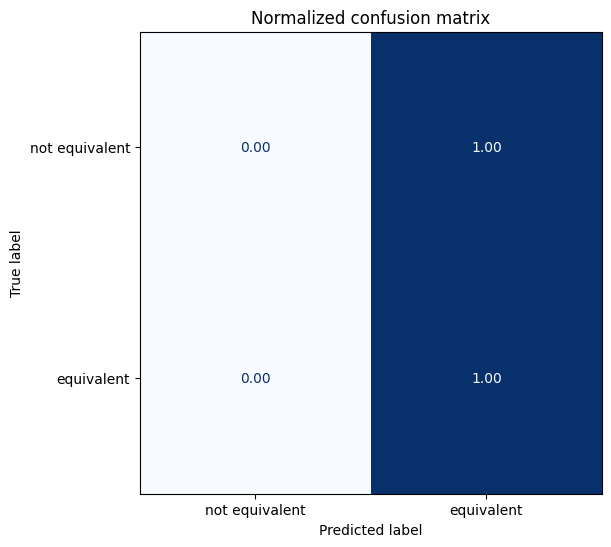

In [35]:
# plot the confusion matrix
## code here
labels = ["not equivalent", "equivalent"]
plot_confusion_matrix(y_preds, y_test, labels)

The shown normalized confusion matrix isn't that good, but perhaps if we were to train more then a better one will be shown. We can do this by increasing the epochs in the training arguments. This is one way of finetuning.

## Train the LoRA variation of the RoBERTA Model
In this section we are going to fine tune the language model using the LoRA configuration. It will follow a similar procedure as done before.

Consider a bigger model. One that we cannot fine tune all the parameters. What happens if we cannot afford to fine tune a model that has 125 million parameters? That is, our GPU and memory is not allowing us to fine tune. We can use LoRA (Low Rank Adapter) to help us. (see https://www.databricks.com/blog/efficient-fine-tuning-lora-guide-llms, https://huggingface.co/docs/diffusers/v0.32.2/en/api/loaders/lora#lora, and https://en.wikipedia.org/wiki/Fine-tuning_(deep_learning)#Low-rank_adaptation)

The LoraConfig reduces the rank space with the parameter r. LoRA is part of the PEFT (Parameter Efficient Fine Tuning) library on HuggingFace. LoRA is not by default in the Transformers. There are multiple PEFT task types (see https://huggingface.co/docs/peft/package_reference/peft_types).

Resource:

LoRA: Low-Rank Adaptation of Large Language Models (https://arxiv.org/pdf/2106.09685)

Low-Rank Adapter LoRA Explained (https://medium.com/@shelikohan/low-rank-adapter-lora-explained-0d3677395639)

In [36]:
# let us now get the LoRA confirguration
# get the lora configuration of the model
# in order to do this use lora_config and choose the appropriate rank

## code here
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=32, lora_alpha=1, lora_dropout=0.1)

In [37]:
# now create the pretained model using the RoBERTA path
# and wrap it around the lora configuration
# afterwards print out the number of trainable parameters
# what do you notice with the original roberta model?

## code here
model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, return_dict=True)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,771,778 || all params: 126,418,948 || trainable%: 1.4015


Regarding the training arguments, one thing to note is that before when we train the LLM choosing the learning_rate is critical so that information is not lost. For LoRA, this isn't the case. For a specialized task, using LoRA for training is better. For a full task, LoRA is not optimal.

In [38]:
# in a similar way as before,
# write out the training arguments that you wish
# to use for the lora configuration of Roberta.

## code here
training_args = TrainingArguments(
    output_dir="ik_test/roberta-base-peft-p-tuning",
    learning_rate=1e-3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    load_best_model_at_end=True,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Notice that if you compare this Trainer object to the previous Trainer object, nothing has changed. The change is in the model, i.e., LoRA was applied.

In [39]:
# similarly as before write down the Trainer
# object and with your training arguments, lora model
# datasets, tokenizer, data collator, and compute metrics

## code here
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# train the model
## code here
trainer.train()

<ipython-input-39-747e88e4de0f>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.622000,0.544938,0.749565,0.827476
2,0.506700,0.407117,0.805797,0.864865
3,0.425900,0.349696,0.839420,0.881269
4,0.371700,0.337543,0.846377,0.887186


TrainOutput(global_step=460, training_loss=0.46890073029891305, metrics={'train_runtime': 181.9602, 'train_samples_per_second': 80.633, 'train_steps_per_second': 2.528, 'total_flos': 617951048233344.0, 'train_loss': 0.46890073029891305, 'epoch': 4.0})

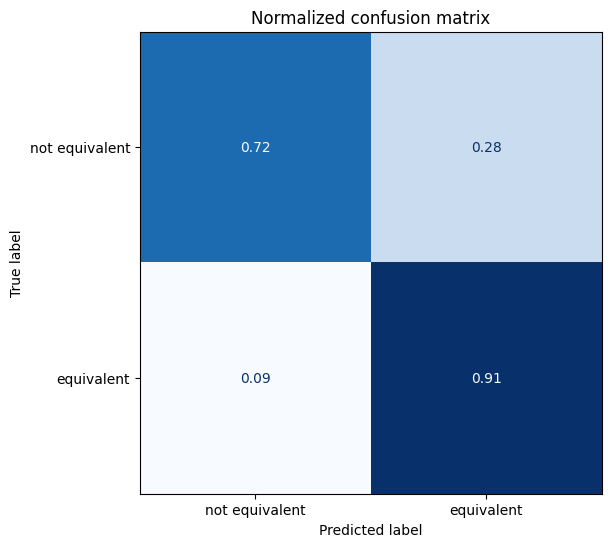

In [40]:
# get the training predictions
# as well as the test target outputs
# lastly plot the confusion matric

## code here
y_preds = np.argmax(trainer.predict(tokenized_datasets["test"]).predictions, axis=1)
y_test = tokenized_datasets["test"]['labels']
labels = ["not equivalent", "equivalent"]
plot_confusion_matrix(y_preds, y_test, labels)

Now we are ready to begin testing our LoRA model on test data that we generate ourselves. We are providing two sentences and the code in order to determine semantic similarity. Afterwards, you can test some yourselves.

In [41]:
# let's look at a specific example
# and see what the trained model will do on two samples
# that are not necessarily in the training or valiudation data

## here is the code to take in two sentences, tokenize them,
## and generate model logit outputs. Lastly, we are going to generate predictions
## for each classes.
def get_preds(sentence1, sentence2, classes=["not equivalent", "equivalent"]):
  inputs = tokenizer(sentence1,
                     sentence2,
                     truncation=True,
                     padding="longest",
                     return_tensors="pt").to("cuda")
  with torch.no_grad():
    outputs = trainer.model(**inputs).logits
    print(outputs)

  paraphrased_text = torch.softmax(outputs, dim=1).tolist()[0]
  for i in range(len(classes)):
      print(f"{classes[i]}: {int(round(paraphrased_text[i] * 100))}%")


## here are two sentences and we'd like to understand
## if the two sentences are equivalent
sentence1 = "Coast redwood trees are the tallest trees on the planet and can grow over 300 feet tall."
sentence2 = "The coast redwood trees, which can attain a height of over 300 feet, are the tallest trees on earth."
## run the get_preds function with these two sentences

## code here
get_preds(sentence1, sentence2)

tensor([[-2.0304,  1.8988]], device='cuda:0')
not equivalent: 2%
equivalent: 98%


In [42]:
## go ahead and chose two sentences and
## check if they are semantically equivalent
## what do you notice about the sentences you choose?

sentence1 = 'Howdy, my name is Harry and I like data science'
sentence2 = 'Howdy, my name is Albert and I like mathematics'
get_preds(sentence1, sentence2)

tensor([[-0.7960,  0.6250]], device='cuda:0')
not equivalent: 19%
equivalent: 81%


In [ ]:
# Evaluate
# Datasets
# Tokenizers
# Transformer
# Peft